# Import Libraries

In [ ]:
# Only need to run this if `nibabel` is not installed

#!pip install nibabel

In [1]:
import os
import random
import glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from google.colab import drive

import keras
import tensorflow as tf
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import zoom


In [ ]:
tf.__version__

'2.13.0'

In [ ]:
keras.__version__

'2.13.1'

## Mount Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Switch Board
The following is a switch board which will allow you to determine whether to use sample dataset or full.

In [3]:
full_or_sample = input("[F]ull or [S]ample Dataset? ")
try:
  if full_or_sample[0].lower() == 'f':
      dataset_dir = "/content/drive/MyDrive/kits23-sample/dataset"
      dataset_folder_path = '/content/drive/MyDrive/kits23-sample/dataset'
  elif full_or_sample[0].lower() == 's':
      dataset_dir = "/content/drive/MyDrive/kits23-sample/dataset"
      dataset_folder_path = '/content/drive/MyDrive/kits23-sample/dataset'
  else:
    raise Exception()
except:
  print("Please use either [F] or [S]")

[F]ull or [S]ample Dataset? sample


## Collection of Custom Functions

In [ ]:
# list all the files in a directory

import os
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        sub_indent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(sub_indent, f))

# list_files(dataset_folder_path)

In [4]:
# obtain all the case names in a list for further downstream use
def get_all_case_dirs(root_path):
    """Get all case directories under the root path."""
    paths = [os.path.join(root_path, d) for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]
    return paths

# safely load the data using the 'nibabel' library (used for visualising images and data-generator)
def safe_load_nii_gz_data(case_path, filename):
    """Load .nii.gz data using nibabel, return None if file doesn't exist."""
    file_path = os.path.join(case_path, filename)
    if os.path.exists(file_path):
        nii_data = nib.load(file_path)
        return nii_data.get_fdata(dtype = np.float16)
    else:
        print(f"File {file_path} not found.")
        return None

# visualize the absolute middle slice of a given case
def visualize_slice(data):
    """Visualize a slice of the 3D data."""
    plt.imshow(data[data.shape[0] // 2, :, :].T, cmap="gray")
    plt.show()

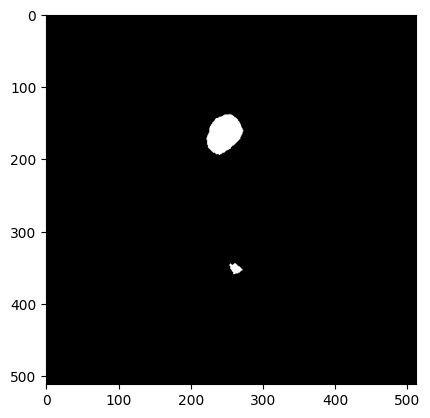

(190, 512, 512)
<class 'numpy.ndarray'>
Number of unique labels in segmentation file:  [0. 1. 2.]


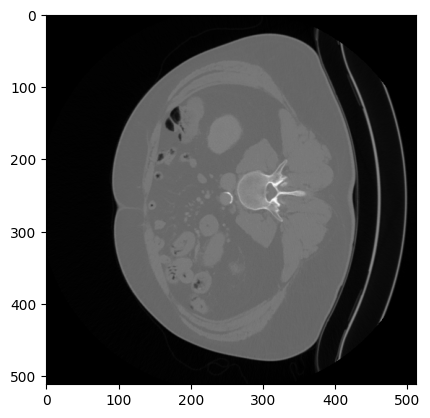

In [ ]:
all_case_dirs = get_all_case_dirs(dataset_dir)
random.shuffle(all_case_dirs)
# Loading segmentations for the first few cases and visualize the first one that works
for case_dir in all_case_dirs[:1]:  # only testing first 10 for quick verification
    if case_dir.endswith('.ipynb_checkpoints') : continue
    segmentation_data = safe_load_nii_gz_data(case_dir, "segmentation.nii.gz")
    image_data = safe_load_nii_gz_data(case_dir, "imaging.nii.gz")
    if segmentation_data is not None:
        visualize_slice(segmentation_data)
        print(segmentation_data.shape)
        print(type(segmentation_data))
        print("Number of unique labels in segmentation file: ", np.unique(segmentation_data))
        visualize_slice(image_data)
        print(image_data.shape)

## Explicit Labels of Segmentation Data

In [ ]:
seg_file = nib.load("/content/drive/MyDrive/kits23-sample/dataset/case_21/segmentation.nii.gz").get_fdata()
seg_file = seg_file.astype(np.uint8)

print(np.unique(seg_file))

[0 1 2 3]


#Filtering Out Incomplete Data

### Data Preparation

Cleaning the dataset by identifying and removing any cases that lack the segmentation.nii.gz file. If a case lacks segmentation.nii.gz, it implies that we don't have a reference segmentation for that particular case, making it unsuitable for training (since we wouldn't have a ground truth to compare the model's output to).

In [ ]:
# List all cases
all_cases = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

In [ ]:
# Filter cases that have segmentation.nii.gz and at least one instance
valid_cases = [
    case
    for case in all_cases
    if os.path.exists(os.path.join(dataset_dir, case, "segmentation.nii.gz")) and
    os.path.exists(os.path.join(dataset_dir, case, "imaging.nii.gz"))
]

print(f"Total cases: {len(all_cases)}")
print(f"Valid cases with segmentation and at least one instance: {len(valid_cases)}")

Total cases: 39
Valid cases with segmentation and at least one instance: 38


In [ ]:
# Print the names of the valid cases in order
print("\nNames of valid cases:")
for case_name in sorted(valid_cases):
    print(case_name)

In [ ]:
set(all_cases) - set(valid_cases)

{'.ipynb_checkpoints'}

# Data Preprocessing | ONLY NEED TO DO THIS ONCE
- one_hot_encoding |
    - returns a one-hot-encoding of the segmentation labels
- preprocess_data |
    - takes an image, determines whether the number of slices are less, equal or greater than target number of slices.
    - if less than target = interpolation (cubic) is used via 'zoom' function
    - if greater than target = downsampling is used by selecting a number of slices until target number of slices is achieved

In [ ]:
def one_hot_encode(segmentation, num_classes):
    """
    One hot encodes the segmentation mask.
    Args:
    - segmentation : numpy array, the segmentation mask
    - num_classes : int, number of classes
    Returns:
    - one_hot : numpy array, the one-hot encoded mask
    """
    one_hot = np.zeros((*segmentation.shape, num_classes))
    for i in range(num_classes):
        one_hot[..., i] = (segmentation == i)
    return one_hot


In [4]:
image_list = sorted(glob.glob("/content/drive/MyDrive/kits23-sample/dataset/*/imaging.nii.gz"))

In [5]:
segmentation_list = sorted(glob.glob("/content/drive/MyDrive/kits23-sample/dataset/*/segmentation.nii.gz"))

In [ ]:
# NEED TO INCLUDE WAY TO DIVERT CASES FOR TRAINING AND VALIDATION

TARGET_NUM_SLICES = 256

for img in range(len(image_list)):
  try:
      imaging_data = nib.load(image_list[img]).get_fdata()
      imaging_data - imaging_data.astype(np.float16)
      segmentation_data = nib.load(segmentation_list[img]).get_fdata()
      segmentation_data = segmentation_data.astype(np.uint8)

      current_num_slices, height, width = imaging_data.shape

      # Calculate the scaling factor for Y and X dimensions
      y_scale_factor = 0.5
      x_scale_factor = 0.5

      # Upsample the Y and X dimensions using cubic interpolation
      resampled_volume_image = zoom(imaging_data, (1, y_scale_factor, x_scale_factor), order=3)
      resampled_volume_segment = zoom(segmentation_data, (1, y_scale_factor, x_scale_factor), order=3)

      if current_num_slices == TARGET_NUM_SLICES:
          # No need to adjust the Z dimension
          pass

      elif current_num_slices < TARGET_NUM_SLICES:
          # Upsample the Z dimension using cubic interpolation
          z_scale_factor = TARGET_NUM_SLICES / current_num_slices
          resampled_volume_image = zoom(resampled_volume_image, (z_scale_factor, 1, 1), order=3)
          resampled_volume_segment = zoom(resampled_volume_segment, (z_scale_factor, 1, 1), order=3)

      else:  # current_num_slices > target_num_slices
          # Downsample the Z dimension by selecting equidistant slices
          step_size = int(current_num_slices // TARGET_NUM_SLICES)
          selected_slices_image = [resampled_volume_image[i, :, :] for i in range(0, current_num_slices, step_size)][:TARGET_NUM_SLICES]
          resampled_volume_image = np.stack(selected_slices_image, axis=0)
          selected_slices_segment = [resampled_volume_segment[i, :, :] for i in range(0, current_num_slices, step_size)][:TARGET_NUM_SLICES]
          resampled_volume_segment = np.stack(selected_slices_segment, axis=0)

      # Normalize both imaging and segmentation data between 0 and 1
      scaler = MinMaxScaler()
      imaging_data = scaler.fit_transform(resampled_volume_image.reshape(-1, resampled_volume_image.shape[-1])).reshape(resampled_volume_image.shape)

      # Convert segmentation to categorical with 4 classes

      val, counts = np.unique(resampled_volume_segment, return_counts = True)

      if (1 - (counts[0]/counts.sum())) > 0.02:
          segmentation_data = tf.keras.utils.to_categorical(resampled_volume_segment, num_classes=4)
          # Save the preprocessed data as numpy arrays
          np.save("/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Images/image_"+str(img)+'.npy', imaging_data)
          np.save("/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Segmentations/segmentation_"+str(img)+'.npy', segmentation_data)

          print(f"Preprocessing completed for case_{img}.")

      else:
          print(f"Skipping case_{img} as there is not enough useful data")

  except Exception as e:
      print(e)
      continue


Preprocessing completed for case_0.
Preprocessing completed for case_1.
Preprocessing completed for case_2.
Preprocessing completed for case_3.
Preprocessing completed for case_4.
Preprocessing completed for case_5.
index 4 is out of bounds for axis 1 with size 4
Preprocessing completed for case_7.
Preprocessing completed for case_8.
Preprocessing completed for case_9.
Preprocessing completed for case_10.
Preprocessing completed for case_11.
index 4 is out of bounds for axis 1 with size 4
Preprocessing completed for case_13.
Preprocessing completed for case_14.
Preprocessing completed for case_15.
Preprocessing completed for case_16.
index 4 is out of bounds for axis 1 with size 4
index 4 is out of bounds for axis 1 with size 4
index 4 is out of bounds for axis 1 with size 4
Preprocessing completed for case_20.
index 4 is out of bounds for axis 1 with size 4
Preprocessing completed for case_22.
Preprocessing completed for case_23.
Preprocessing completed for case_24.
Preprocessing comp

## Validation of Numpy Arrays stored to Directory

[Errno 2] No such file or directory: '/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Train/Images/image_2.npy'
[Errno 2] No such file or directory: '/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Train/Images/image_3.npy'
[Errno 2] No such file or directory: '/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Train/Images/image_4.npy'


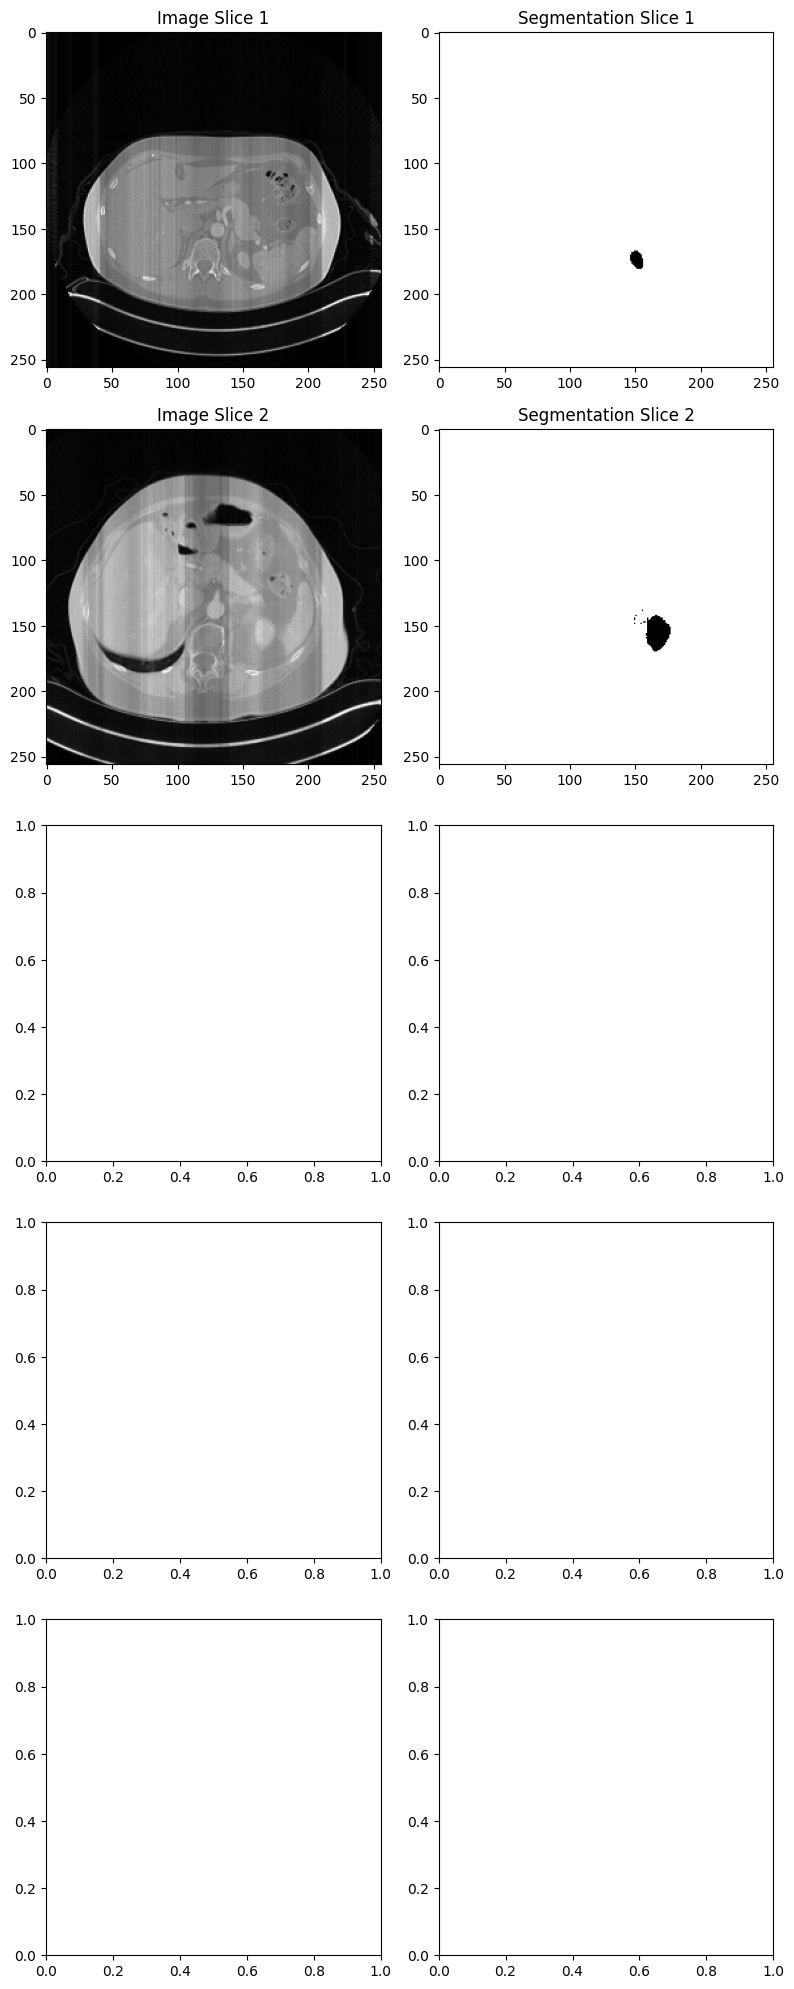

In [ ]:

num_slices = 5

# Create a figure with subplots
fig, axes = plt.subplots(num_slices, 2, figsize=(8, 4 * num_slices))

# Iterate through slices and display image and segmentation
for i in range(num_slices):
    try:
        image_slices = np.load(f"/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Images/image_{i}.npy")
        # Display the image slice
        axes[i, 0].imshow(image_slices[i+50], cmap='gray')
        axes[i, 0].set_title(f'Image Slice {i+1}')

        # Display the segmentation slice
        segmentation_slices = np.load(f"/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Segmentations/segmentation_{i}.npy")
        axes[i, 1].imshow(segmentation_slices[i+50,:,:,1], cmap='gray_r')  # You can choose a different colormap
        axes[i, 1].set_title(f'Segmentation Slice {i+1}')
    except Exception as e:
      print(e)
      continue

# Add spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Splitting into Training, Testing and Validation Folders

In [ ]:
# import shutil

# # Define paths to the source folders (images and masks) and the destination folders (train, validation, test)
# src_images_folder = '/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Images/'
# src_masks_folder = '/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Segmentations/'
# dest_folder = '/content/drive/MyDrive/kits23-sample/Preprocessed_Data/'

# # Define the split ratios
# train_ratio = 0.7  # 70% for training
# validation_ratio = 0.15  # 15% for validation
# test_ratio = 0.15  # 15% for testing

# # Create destination directories
# train_dest = os.path.join(dest_folder, 'Train')
# val_dest = os.path.join(dest_folder, 'Validation')
# test_dest = os.path.join(dest_folder, 'Test')

# os.makedirs(train_dest, exist_ok=True)
# os.makedirs(val_dest, exist_ok=True)
# os.makedirs(test_dest, exist_ok=True)

# # Get the list of image and mask files
# image_files = [filename for filename in os.listdir(src_images_folder) if filename.startswith("image")]
# mask_files = [filename for filename in os.listdir(src_masks_folder) if filename.startswith("segmentation")]

# # Shuffle the list of files
# random.shuffle(image_files)

# # Calculate the number of files for each split
# num_samples = len(image_files)
# num_train = int(train_ratio * num_samples)
# num_val = int(validation_ratio * num_samples)
# num_test = num_samples - num_train - num_val

# # Copy files to the destination folders based on the split ratios
# for i, image_file in enumerate(image_files):
#     src_image_path = os.path.join(src_images_folder, image_file)

#     # Extract the corresponding mask filename based on the image filename
#     mask_filename = "segmentation" + f"{image_file[5:]}"  # Replace "image" with "segmentation" in the filename

#     src_mask_path = os.path.join(src_masks_folder, mask_filename)

#     if i < num_train:
#         dest_folder = train_dest
#     elif i < num_train + num_val:
#         dest_folder = val_dest
#     else:
#         dest_folder = test_dest

#     dest_image_path = os.path.join(dest_folder, 'Images', image_file)
#     dest_mask_path = os.path.join(dest_folder, 'Segmentations', mask_filename)

#     # Copy the image and mask to the destination folder
#     shutil.move(src_image_path, dest_image_path)
#     shutil.move(src_mask_path, dest_mask_path)

# print("Data split completed.")


Data split completed.


#Generator : data is loaded and preprocessed on-the-fly during training

In [ ]:
# #Each batch is consistent and has a shape (batch_size, 128, 128, 64, 1) for images and (batch_size, 128, 128, 64, num_classes) for labels
# def data_generator(case_list, dataset_dir, batch_size=2, image_shape=(256, 256, 256, 1), num_classes=4):
#     while True:
#         # Randomly sample batch_size cases
#         batch_cases = np.random.choice(case_list, size=batch_size)

#         batch_images = []
#         batch_labels = []

#         for case in batch_cases:
#             instances_dir = os.path.join(dataset_dir, case)

#             # List all instance files within the directory
#             all_files = os.listdir(instances_dir)

#             # Filter out the kidney, cyst, and tumor instances
#             image_files = [f for f in all_files if f.startswith("imaging")]

#             # print(image_files)

#             if not image_files:
#                 continue  # If there are no instance files, skip this case

#             # Select a random instance for this case (assuming each case might have different instances)
#             random_instance = np.random.choice(image_files)

#             image_path = os.path.join(instances_dir, random_instance)
#             label_path = os.path.join(dataset_dir, case, 'segmentation.nii.gz')

#             # Load the image and label
#             image = nib.load(image_path).get_fdata()
#             label = nib.load(label_path).get_fdata()

#             #print(np.unique(label))

#             # Preprocess (resize and normalize) the image and label
#             image, label = preprocess_data(image, label)

#             # One-hot encode the labels
#             #label = one_hot_encode(label, num_classes=num_classes)

#             batch_images.append(image)
#             batch_labels.append(label)

#         # Ensure batch size consistency
#         while len(batch_images) < batch_size:
#             # simply reuse the data from the current batch. This is a basic approach, may change it
#             batch_images.extend(batch_images[:batch_size - len(batch_images)])
#             batch_labels.extend(batch_labels[:batch_size - len(batch_labels)])

#         # Convert lists to numpy arrays and try to reshape them to ensure the consistency
#         batch_images = np.array(batch_images)
#         batch_labels = np.array(batch_labels)

#         # Print the shapes before reshaping
#         # print("Shapes before reshaping:", batch_images.shape, batch_labels.shape)

#         try:
#             batch_images = batch_images.reshape((batch_size, *image_shape))
#             batch_labels = batch_labels.reshape((batch_size, *image_shape[:-1], num_classes))
#         except ValueError as e:
#             print(f"Error reshaping for batch: {e}")
#             print("Cases in the problematic batch:", batch_cases)
#             continue  # Skip the problematic batch

#         yield (batch_images, batch_labels)

In [13]:
# https://github.com/bnsreenu/python_for_microscopists/blob/master/231_234_BraTa2020_Unet_segmentation/233_custom_datagen.py

def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):

            image = np.load(img_dir+image_name)
            image.astype(np.float16)

            if (image_name.startswith("image")):
                image_with_channel = np.expand_dims(image, axis=-1)
                images.append(image_with_channel)
            else:
                images.append(image)
    images = np.array(images)

    return(images)

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

In [14]:
train_img_dir = "/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Train/Images/"
train_mask_dir = "/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Train/Segmentations/"
train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

valid_img_dir = "/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Validation/Images/"
valid_mask_dir = "/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Validation/Segmentations/"
valid_img_list = os.listdir(valid_img_dir)
valid_mask_list = os.listdir(valid_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

valid_img_datagen = imageLoader(valid_img_dir, valid_img_list,
                                valid_mask_dir, valid_mask_list, batch_size)

In [15]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

print("Image Size: ", img.shape)
print("Mask Size: ", msk.shape)

Image Size:  (2, 256, 256, 256, 1)
Mask Size:  (2, 256, 256, 256, 4)


#Model

###Define the U-Net Model

In [6]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda, Cropping3D
from keras.optimizers import Adam
from keras.metrics import MeanIoU

In [7]:
kernel_initializer =  'he_uniform'

## 3D-UNet Small

In [8]:
#https://github.com/bnsreenu/python_for_microscopists/blob/master/231_234_BraTa2020_Unet_segmentation/simple_3d_unet.py

def simple_unet_model_small(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):

    #Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv3D(2, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same',
                data_format = "channels_last")(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(2, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(4, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(4, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(8, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(8, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(12, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(12, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(16, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(16, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(12, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(12, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(12, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(8, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(8, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(8, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(4, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(4, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(4, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(2, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(2, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(2, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    # model.summary()

    return model

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_DEPTH = 256
IMG_CHANNELS = 1
num_classes = 4

#Test if everything is working ok.
baseline_model = simple_unet_model_small(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes)
print(baseline_model.input_shape)
print(baseline_model.output_shape)

(None, 256, 256, 256, 1)
(None, 256, 256, 256, 4)


In [ ]:
# #https://github.com/bnsreenu/python_for_microscopists/blob/master/231_234_BraTa2020_Unet_segmentation/simple_3d_unet.py

# def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):

#     #Build the model
#     inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
#     s = inputs

#     #Contraction path
#     c1 = Conv3D(2, 4, activation='relu', kernel_initializer=kernel_initializer, padding='same',
#                 data_format = "channels_last")(s)
#     c1 = Dropout(0.1)(c1)
#     c1 = Conv3D(2, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
#     p1 = MaxPooling3D((2, 2, 2))(c1)

#     c2 = Conv3D(4, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
#     c2 = Dropout(0.1)(c2)
#     c2 = Conv3D(4, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
#     p2 = MaxPooling3D((2, 2, 2))(c2)

#     c3 = Conv3D(8, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
#     c3 = Dropout(0.2)(c3)
#     c3 = Conv3D(8, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
#     p3 = MaxPooling3D((2, 2, 2))(c3)

#     c4 = Conv3D(12, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
#     c4 = Dropout(0.2)(c4)
#     c4 = Conv3D(12, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
#     p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

#     c5 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
#     c5 = Dropout(0.3)(c5)
#     c5 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

#     #Expansive path
#     u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
#     u6 = concatenate([u6, c4])
#     c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
#     c6 = Dropout(0.2)(c6)
#     c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

#     u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
#     u7 = concatenate([u7, c3])
#     c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
#     c7 = Dropout(0.2)(c7)
#     c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

#     u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
#     c8 = Dropout(0.1)(c8)
#     c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

#     u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
#     u9 = concatenate([u9, c1])
#     c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
#     c9 = Dropout(0.1)(c9)
#     c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

#     outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

#     model = Model(inputs=[inputs], outputs=[outputs])
#     #compile model outside of this function to make it flexible.
#     model.summary()

#     return model

# IMG_HEIGHT = 256
# IMG_WIDTH = 256
# IMG_DEPTH = 256
# IMG_CHANNELS = 1
# num_classes = 4

# #Test if everything is working ok.
# baseline_model_PASS = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes)
# print(baseline_model.input_shape)
# print(baseline_model.output_shape)

## Calculate Class Weightings

In [18]:
import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Train/Segmentations/*.npy'))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)

    df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['2'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

print("Class 0 (Background): ", wt0)
print("Class 1 (Kidneys):    ", wt1)
print("Class 2 (Tumor):      ", wt2)
print("Class 3 (Cyst):       ", wt3)

print(conts_dict)

0


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


1


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


2


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


3


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


4


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


5


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


6


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


7


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


8


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


9


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


10


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


11


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


12


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


13


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


14


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


15


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


16


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


17


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


18
Class 0 (Background):  0.25
Class 1 (Kidneys):     35.16
Class 2 (Tumor):       383.91
Class 3 (Cyst):        1943701.85
{'0': 16647398, '1': 124668, '2': 5150}


<ipython-input-18-029adcd5b427>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


##Define Losses, Metrics and Optimisers

In [9]:
# https://stackoverflow.com/questions/66023106/how-to-create-hybrid-loss-consisting-from-dice-loss-and-focal-loss-python

# def dice_coef(y_true, y_pred, smooth=1e-16):
#     y_true_f = tf.nest.flatten(y_true)
#     y_pred_f = tf.nest.flatten(y_pred)
#     intersection = tf.math.reduce_sum(tf.math.multiply(y_true_f, y_pred_f))
#     return (2. * intersection + smooth) / (tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) + smooth)

# def dice_coef_multilabel(y_true, y_pred, numLabels=4):
#     dice=0
#     for index in range(numLabels):
#         dice -= dice_coef(y_true[..., index], y_pred[..., index])
#     return numLabels + dice

In [19]:

def weighted_dice_loss(class_weights):
    def dice_coef(y_true, y_pred, smooth=1.0):
        intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
        union = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
        return tf.reduce_mean((2.0 * intersection + smooth) / (union + smooth))

    def loss(y_true, y_pred):
        dice_scores = dice_coef(y_true, y_pred)
        weighted_dice_scores = dice_scores * class_weights
        return 1.0 - tf.reduce_sum(weighted_dice_scores)

    return loss

In [10]:
# It would be ideal to use IOUScore as another metric
metrics = ['accuracy', keras.metrics.MeanIoU(4)]

In [11]:
STEPS_PER_EPOCH = len("/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Train/Images") // batch_size
validation_steps = len("/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Validation/Images") // batch_size  # similar calculation for validation data
# lr = 0.0001

# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#   lr,
#   decay_steps=STEPS_PER_EPOCH*1000,
#   decay_rate=10,
#   staircase=False)

# optimizer_Adam = Adam(learning_rate=lr_schedule)

#Train Model

## Set Up Callbacks

In [12]:
def create_model_cp_dir(model_name):
  if full_or_sample[0].lower() : parent_directory = "/content/drive/MyDrive/kits23-sample/CheckPointing/"
  elif full_or_sample[0].lower() : parent_directory = "/content/drive/MyDrive/kits23/CheckPointing/"
  leaf_directory = parent_directory + model_name + "/"
  full_directory = leaf_directory + model_name + ".{epoch:04d}-{val_loss:.4f}.ckpt"
  if not os.path.exists(leaf_directory):
    os.mkdir(leaf_directory)
  return full_directory

def create_saved_model_dir(model_name):
  if full_or_sample[0].lower() : parent_directory = "/content/drive/MyDrive/kits23-sample/SavedModels/"
  elif full_or_sample[0].lower() : parent_directory = "/content/drive/MyDrive/kits23/SavedModels/"
  leaf_directory = parent_directory + model_name + "/"
  full_directory = leaf_directory + model_name + ".h5"
  if not os.path.exists(leaf_directory):
    os.mkdir(leaf_directory)
  return full_directory

def get_callbacks(model_name):
  return [
    # tf.keras.callbacks.TensorBoard(logdir/str(model_name), histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(create_model_cp_dir(model_name),
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 monitor = 'val_loss',
                                                 mode = 'min',
                                                 save_best_only = True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  ]

## Compile Model

In [13]:
# We should include callbacks e.g. Early Stopping
baseline_model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=weighted_dice_loss(np.array([wt0, wt1, wt2, wt3])),
              metrics=metrics)

This cell will take about 20 -30 mins to run.


In [14]:
tf.keras.backend.clear_session()

In [15]:
baseline_history=baseline_model.fit(train_img_datagen,
          steps_per_epoch=STEPS_PER_EPOCH,
          epochs=10,
          verbose=2,
          validation_data=valid_img_datagen,
          validation_steps=validation_steps,
          callbacks = [get_callbacks("baseline_sample_model")]
          )

Epoch 1/10

Epoch 1: val_loss improved from inf to 3.00771, saving model to /content/drive/MyDrive/kits23-sample/CheckPointing/baseline_sample_model/baseline_sample_model.0001-3.0077.ckpt
33/33 - 372s - loss: 3.2068 - accuracy: 0.8099 - mean_io_u: 0.5531 - val_loss: 3.0077 - val_accuracy: 0.9869 - val_mean_io_u: 0.9448 - 372s/epoch - 11s/step
Epoch 2/10

Epoch 2: val_loss improved from 3.00771 to 3.00591, saving model to /content/drive/MyDrive/kits23-sample/CheckPointing/baseline_sample_model/baseline_sample_model.0002-3.0059.ckpt
33/33 - 188s - loss: 3.0051 - accuracy: 0.9910 - mean_io_u: 0.9562 - val_loss: 3.0059 - val_accuracy: 0.9885 - val_mean_io_u: 0.9554 - 188s/epoch - 6s/step
Epoch 3/10

Epoch 3: val_loss improved from 3.00591 to 3.00573, saving model to /content/drive/MyDrive/kits23-sample/CheckPointing/baseline_sample_model/baseline_sample_model.0003-3.0057.ckpt
33/33 - 188s - loss: 3.0043 - accuracy: 0.9917 - mean_io_u: 0.9677 - val_loss: 3.0057 - val_accuracy: 0.9886 - val_

In [16]:
create_saved_model_dir("baseline_model_sample")

'/content/drive/MyDrive/kits23-sample/SavedModels/baseline_model_sample/baseline_model_sample.h5'

In [17]:
import h5py
baseline_model.save("/content/drive/MyDrive/kits23-sample/SavedModels/baseline_model_sample")

# Plot Metrics

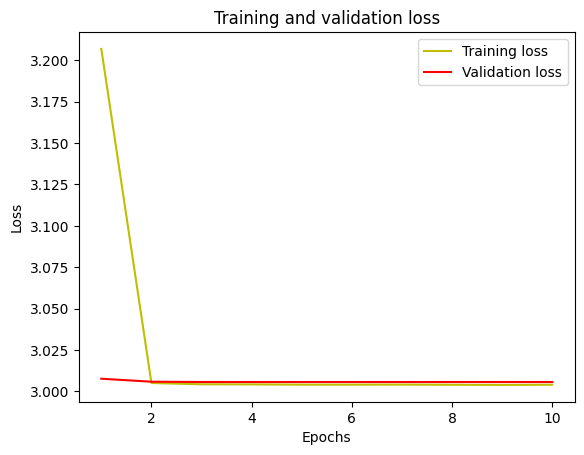

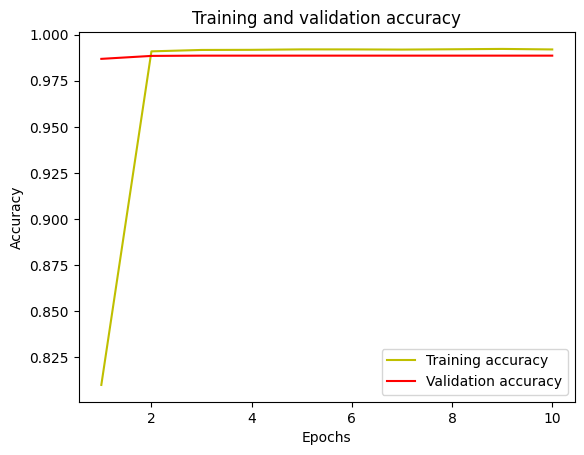

In [18]:
loss = baseline_history.history['loss']
val_loss = baseline_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = baseline_history.history['accuracy']
val_acc = baseline_history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



# Make Predictions on Unseen Data

In [63]:
test_img_dir = "/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Test/Images/"
test_mask_dir = "/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Test/Segmentations/"
test_img_list = os.listdir(test_img_dir)
test_mask_list = os.listdir(test_mask_dir)

batch_size = 1

test_img_datagen = imageLoader(test_img_dir, test_img_list,
                                test_mask_dir, test_mask_list, batch_size)

In [64]:
test_image_batch, test_mask_batch = test_img_datagen.__next__()

In [65]:
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)

In [66]:
test_pred_batch = baseline_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 0s 90ms/step
Mean IoU = 0.33061764


# Visualize Slice with Prediction

In [52]:
test_img = np.load("/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Test/Images/image_4.npy")
test_mask = np.load("/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Test/Segmentations/segmentation_4.npy")

In [79]:
np.unique(np.argmax(test_mask, axis = 3))

array([0, 1, 2, 3])

In [76]:
# Load your 3D volume and labels
volume_data = np.load("/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Test/Images/image_2.npy")  # Replace with your 3D volume file path
labels = np.load("/content/drive/MyDrive/kits23-sample/Preprocessed_Data/Test/Segmentations/segmentation_2.npy")          # Replace with your labels file path

# Count the number of voxels per class
num_classes = len(np.unique(np.argmax(labels, axis = 3)))
class_counts = np.zeros(num_classes)

for class_idx in range(num_classes):
    class_counts[class_idx] = np.sum(labels == class_idx)

# Calculate class frequencies with Laplace smoothing (add 1 to avoid zero counts)
total_voxels = np.prod(labels.shape)
class_frequencies = (class_counts + 1) / (total_voxels + num_classes)

# Calculate class weights (inverse class frequency)
class_weights = 1.0 / class_frequencies

# Optionally, normalize the class weights to sum to 1
class_weights /= np.sum(class_weights)

print("Class Weights:", class_weights)


Class Weights: [1.98682130e-08 5.96046365e-08 9.99999921e-01]


In [61]:
test_mask_argmax = np.argmax(test_mask, axis=3)
test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = baseline_model.predict(test_img_input, verbose = 1)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))

1/1 [==============================] - 0s 85ms/step


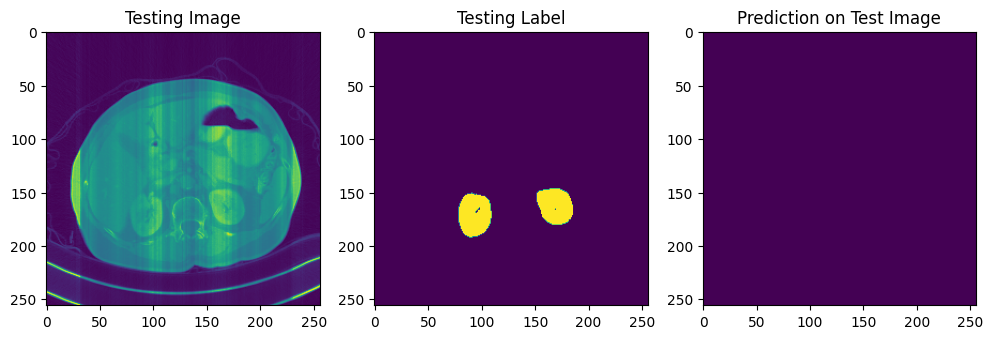

In [62]:
n_slice = 75
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[n_slice,:,:], cmap='viridis')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[n_slice,:,:], cmap= "viridis")
plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(test_prediction_argmax[n_slice,:,:], cmap= "viridis")
plt.show()